## 5.1 Initialization

In [104]:
import numpy as np
import numpy.testing as npt
from scipy.linalg import expm
import matplotlib.pyplot as plt
import scipy.spatial, scipy.linalg
from scipy.spatial.distance import pdist
import scipy.sparse.linalg
from scipy.linalg import eigh
import zipfile,io
import pandas as pd
import zipfile
import re
%matplotlib inline

(a) Load the sound files. Each of the N = 2 sources is sampled at at 8192 Hz and contains p = 18000 samples.

In [105]:
unzip = zipfile.ZipFile("sounds.zip", 'r')          
fl = unzip.namelist()                     
s1 = unzip.open(fl[0])
s2 = unzip.open(fl[1])

In [106]:
dat1 = pd.read_table(s1,header=None,delim_whitespace=True)
dat2 = pd.read_table(s2,header=None,delim_whitespace=True)

In [107]:
sig1 = np.array(dat1)
sig2 = np.array(dat2)
S= np.append(sig1 ,sig2,1)
S

array([[ -0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,  -1.58992990e-04],
       [ -3.77485200e-05,  -3.87545410e-03],
       ..., 
       [  4.35995410e-03,  -4.59092250e-03],
       [ -2.78395330e-03,  -3.24941920e-03],
       [  0.00000000e+00,  -0.00000000e+00]])

(b) Create a random (& invertible) N ×N mixing matrix A and mix the sources: x(α) = As(α)

In [108]:
n = 2
A = np.random.rand(n,n)
print(A)
detA =np.linalg.det(A)
while(detA<0.001):
    A = np.random.rand(n,n)
    detA =np.linalg.det(A)

[[ 0.36115031  0.16490139]
 [ 0.86146413  0.21234799]]


(c) Remove the temporal structure by permuting the columns of the N × p matrix X randomly

In [109]:
X = np.dot(A,S.T)
p = len(X[0])
rmidx = np.random.choice(p,p,replace=False)
XX=X[:,rmidx]

(d) Calculate the correlations between the sources and the mixtures: 

In [110]:
meanx = np.mean(XX,1)
means = np.mean(S,0)
C = np.dot(XX-meanx.reshape(2,1),(S-means))/p
sdx = np.std(XX, axis=1)
sds = np.std(S, axis=0)
print(sdx)
print(sds)
matsdx = (np.ones((2,1))*sdx).T
matsds = (np.ones((2,1))*sds)
print(matsdx)
print(matsds)
corr = C/matsdx/matsds 
print(C)
corr

[ 1.03141925  0.93518652]
[ 0.99854594  0.99885435]
[[ 1.03141925  1.03141925]
 [ 0.93518652  0.93518652]]
[[ 0.99854594  0.99885435]
 [ 0.99854594  0.99885435]]
[[-0.00880834  0.00215459]
 [-0.00781943  0.00172521]]


array([[-0.00855246,  0.00209135],
       [-0.00837354,  0.00184689]])

(e) Center the data to zero mean.


In [111]:
XX = XX -np.mean(XX,1).reshape(n,1)
XX.shape

(2, 18000)

(f) Initialize the unmixing matrix W with random values.

In [112]:

W= np.random.rand(n,n)
detW =np.linalg.det(W)
while(detW<0.001):
    W = np.random.rand(n,n)
    detW =np.linalg.det(W)
print(W)

[[ 0.94449679  0.44455637]
 [ 0.38045324  0.82629959]]


## 5.2 Optimization
Implement a matrix version of the ICA online learning algorithm. For f^use the logistic function(see lecture notes). This should reduce your code for this part to a few lines with one loop (over the samples). Implement two variants of this learning algorithm:

(a) Compute the update matrix ∆W using the “regular” gradient.

In [113]:
def sigmoid(y):
    return 1/(1+np.exp(-y))

In [114]:
def regGrad(XX, W, eps=0.0003):
    dw = np.array(W)
    ww = np.array(W)
    #“regular” gradient online
    for i in range(p):
        if(np.linalg.det(ww)==0.):
            ww = ww+np.eye(n)*0.0000000001
        invW= np.linalg.solve(ww,np.eye(n))
        y = np.dot(ww,XX[:,i].reshape(n,1))
        sig = 1 -2*sigmoid(y)
        dw =invW.T +np.dot(sig,XX[:,i].reshape(1,n))
        ww=ww+eps*dw
    return ww

In [118]:
ww = regGrad(XX, W, eps=0.05)
eps1 = 0.005

In [119]:
ww

array([[ 12.08058067, -11.66462576],
       [-23.24939972,  26.36879371]])

In [120]:
np.linalg.inv(A)

array([[ 23.10974504, -24.83775764],
       [-17.09576815,  19.70331541]])

(b) Compute the update matrix ∆W using the natural gradient as described in the lecture notes.

In [121]:
def natGrad(XX, W, eps=0.001):
    dw = np.array(W)
    ww = np.array(W)
    # natural gradient  
    for i in range(p):
        y = np.dot(ww,XX[:,i].reshape(n,1))
        sig = 1 -2*sigmoid(y)
        dw= ww + np.dot(np.dot(sig,XX[:,i].reshape(1,n)),np.dot(ww.T,ww))
        ww=ww+eps*dw
    return ww

In [137]:
ww = natGrad(X, W, eps=0.0005)
eps2 = 0.005

In [138]:
ww

array([[ 11.57558579,  -9.94250702],
       [-77.44057674,  87.59268763]])

In [139]:
np.linalg.inv(A)

array([[ 23.10974504, -24.83775764],
       [-17.09576815,  19.70331541]])

(c) Choose a suitable learning rate " and apply both versions to the data to unmix the sources.

With our experiment by online lerning of regular gradient and natural gradient we found that best eps are:

For regular: eps=0.005

For natural: eps=0.0003

## 5.3 Results

In [140]:
#A=np.array([[ 0.81690186,0.39716955],[ 0.45181874,0.32128403]])
#W=np.array([[ 0.13900258,0.11300867],[ 0.72448501,0.71863573]])

In [141]:
from scipy.io.wavfile import write

write('test0.wav', 8192, S[:,0]) # bird sound
write('test1.wav', 8192, S[:,1]) # hallelujah 

write('x_permuted_centered0.wav', 8192, XX[0,:])
write('x_permuted_centered1.wav', 8192, XX[1,:])

In [142]:
def computeCorrelation(x,s, label="X"):
    x_size = x.shape[0]
    data = np.vstack((x,s))
    corrs = np.corrcoef(data)
    corrs_trimmed = corrs[:x_size, x_size:,]

    return corrs_trimmed

In [145]:
def plotExperiment(x, w_init, original_s,  dataset):
    total = x.shape[1]
    x_range = np.array(range(total))
    
    plt.figure(figsize=(10,10))
    
    for i in range(x.shape[0]):
        plt.subplot(5,2,i+1)
        plt.plot(x_range, x[i,:].T)
        plt.title('%s : Mixed signal %d' % (dataset, i+1) )
        plt.xticks([])
        plt.yticks([])
        
    w_reg= regGrad(XX, W, 0.002)
    s_est_reg = np.dot(w_reg,x) 
    corr = computeCorrelation(    s_est_reg, original_s)
    learning_algo = 'reg_grad'
    for i in range(x.shape[0]):
        plt.subplot(5,2,2 + i+1)
        plt.plot(x_range, s_est_reg[i,:].T)
        plt.title('%s : %s %d (corr %.4f)' % (learning_algo, 'De-mixed signal', i+1, corr[i,i]) )
        plt.xticks([])
        plt.yticks([])


    w_nat= natGrad(XX, W, 0.002)
    s_est = np.dot(w_nat,x) 
    corr = computeCorrelation(s_est, original_s)
    learning_algo = 'nat_grad'
    for i in range(x.shape[0]):
        plt.subplot(5,2,4+ i+1)
        plt.plot(x_range, s_est[i,:].T)
        plt.title('%s : %s %d (corr %.4f)' % (learning_algo, 'De-mixed signal', i+1, corr[i,i]) )
        plt.xticks([])
        plt.yticks([])
        
    for i in range(x.shape[0]):
        plt.subplot(5,2,6+ i+1)
        plt.plot(x_range, original_s[i,:].T)
        plt.title('%s %d' % ('Original signal', i+1) )
        plt.xticks([])
        plt.yticks([])




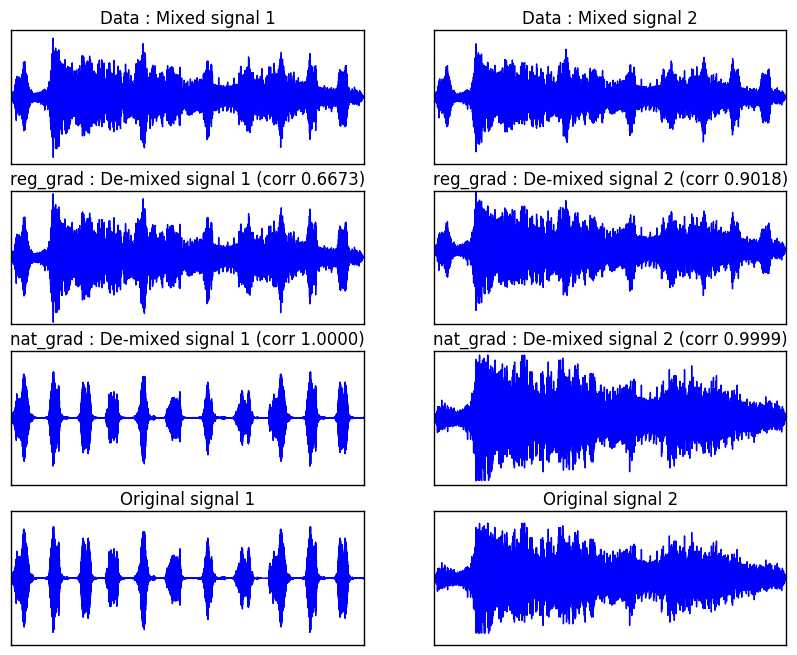

In [146]:
plotExperiment(X, W, S.T, dataset="Data")